# Data Augmentation with Masks

## Data Augmentation

Data Augmentation is a regularization technique that's used to avoid overfitting when training Machine Learning models. Although the technique can be applied in a variety of domains, it's very common in Computer Vision, and this will be the focus of the tutorial. Adjustments are made to the original images in the training dataset before being used in training. Some example adjustments include translating, croping, scaling, rotating, changing brightness and contrast. We do this to reduce the dependence of the model on spurious characteristics; e.g. training data may only contain faces that fill 1/4 of the image, so the model trainied without data augmentation might unhelpfully learn that faces can only be of this size.

<img src="https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/data_aug/outputs/with_mask/orig_vs_aug.png" alt="Drawing" style="width: 480px;"/>

## Masks

Certain Computer Vision tasks (like [Object Segmentation](https://arxiv.org/abs/1506.06204)) require the use of 'masks', and we have to take extra care when using these in conjunction with data augmentation techniques. Given an underlying base image (with 3 channels), a masking channel can be added to provide additional metadata to certain regions of the base image. Masking channels often contain binary values, and these can be used to label a single class, e.g. to label a dog in the foreground. Multi-class segmentation problems could use many binary masking channels (i.e. one binary channel per class), but it is more common to see RGB representations, where each class is a different color. We take an example from the [COCO dataset](http://cocodataset.org/).

<img src="https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/data_aug/outputs/with_mask/masks.png" alt="Drawing" style="width: 700px;"/>

## Data Augmentation with Masks

When we adjust the position of the base image as part of data augmentation, we also need to apply exactly the same operation to the associated masks. An example would be after applying a horizontal flip to the base image, we'd need to also flip the mask, to preserve the corresponsence between the base image and mask.

Color changes to the base image don't need to be applied to the segmentation masks though; and may even lead to errors with the masks. An example with a RGB mask, would be accidentally converting a region of green for dog to blue for cat.

<img src="https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/data_aug/outputs/with_mask/aug_and_mask.png" alt="Drawing" style="width: 800px;"/>

# Custom Dataset

With Gluon it's easy to work with different types of data. You can write custom Datasets and plug them directly into a DataLoader which will handle batching. Segmentation tasks are structured in such a way that the data is the base image and the label is the mask, so we will create a custom Dataset for this. Our Dataset will return base images with their corresponsing masks.

It will be based on the `mx.gluon.data.vision.ImageFolderDataset` for simplicity, and will load files from a single folder, containing images of the form `xyz.jpg` and their corresponsing mask `xyz_mask.png`.

`__getitem__` must be implemented, as this will be used by the DataLoader.

In [1]:
%matplotlib inline
import collections
import mxnet as mx # used version '1.0.0' at time of writing
from mxnet.gluon.data import dataset
import os
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

mx.random.seed(42) # set seed for repeatability


class ImageWithMaskDataset(dataset.Dataset):
    """
    A dataset for loading images (with masks) stored as `xyz.jpg` and `xyz_mask.png`.

    Parameters
    ----------
    root : str
        Path to root directory.
    transform : callable, default None
        A function that takes data and label and transforms them:
    ::
        transform = lambda data, label: (data.astype(np.float32)/255, label)
    """
    def __init__(self, root, transform=None):
        self._root = os.path.expanduser(root)
        self._transform = transform
        self._exts = ['.jpg', '.jpeg', '.png']
        self._list_images(self._root)

    def _list_images(self, root):
        images = collections.defaultdict(dict)
        for filename in sorted(os.listdir(root)):
            name, ext = os.path.splitext(filename)
            mask_flag = name.endswith("_mask")
            if ext.lower() not in self._exts:
                continue
            if not mask_flag:
                images[name]["base"] = filename
            else:
                name = name[:-5] # to remove '_mask'
                images[name]["mask"] = filename
        self._image_list = list(images.values())

    def __getitem__(self, idx):
        assert 'base' in self._image_list[idx], "Couldn't find base image for: " + image_list[idx]["mask"]
        base_filepath = os.path.join(self._root, self._image_list[idx]["base"])
        base = mx.image.imread(base_filepath)
        assert 'mask' in self._image_list[idx], "Couldn't find mask image for: " + image_list[idx]["base"]
        mask_filepath = os.path.join(self._root, self._image_list[idx]["mask"])
        mask = mx.image.imread(mask_filepath)
        if self._transform is not None:
            return self._transform(base, mask)
        else:
            return base, mask

    def __len__(self):
        return len(self._image_list)

## Using our Dataset 

Usually Datasets are used in conjunction with DataLoaders, but we'll sample a single base image and mask pair for testing purposes. Calling `dataset[0]` (which is equivalent to `dataset.__getitem__(0)`) returns the first base image and mask pair from the `_image_list`. At first download the sample images and then we'll load them without any augmentation.

In [2]:
image_dir = os.path.join("data", "images")
mx.test_utils.download('https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/data_aug/inputs/0.jpg', dirname=image_dir)
mx.test_utils.download('https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/data_aug/inputs/0_mask.png', dirname=image_dir)
dataset = ImageWithMaskDataset(root=image_dir)
sample = dataset.__getitem__(0)
sample_base = sample[0].astype('float32')
sample_mask = sample[1].astype('float32')
assert sample_base.shape == (427, 640, 3)
assert sample_mask.shape == (427, 640, 3)

In [3]:
def plot_mx_arrays(arrays):
    """
    Array expected to be height x width x 3 (channels), and values are floats between 0 and 255.
    """
    plt.subplots(figsize=(12, 4))
    for idx, array in enumerate(arrays):
        assert array.shape[2] == 3, "RGB Channel should be last"
        plt.subplot(1, 2, idx+1)
        imshow((array.clip(0, 255)/255).asnumpy())

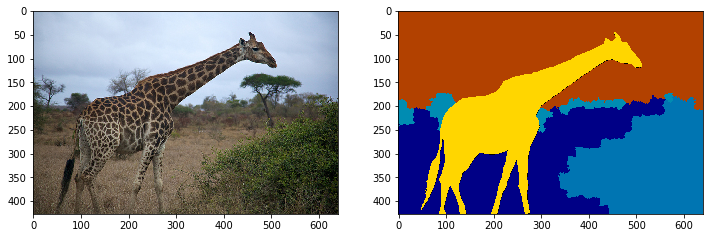

In [4]:
plot_mx_arrays([sample_base, sample_mask])

# Implementing `transform` for Augmentation

We now construct our augmentation pipeline by implementing a transform function. Given a data sample and its corresponding label, this function must also return data and a label. In our specific example, our transform function will take the base image and corresponding mask, and return the augmented base image and correctly augmented mask. We will provide this to the `ImageWithMaskDataset` via the `transform` argument, and it will be applied to each sample (i.e. each data and label pair).

Our approach is to apply positional augmentations to the combined base image and mask, and then apply the color augmentations to the positionally augmented base image only. We concatenate the base image with the mask along the channels dimension. So if we have a 3 channel base image, and a 3 channel mask, the result will be a 6 channel array. After applying positional augmentations on this array, we split out the base image and mask once again. Our last step is to apply the colour augmentation to just the augmented base image.

In [5]:
def positional_augmentation(joint):
    # Random crop
    crop_height = 200
    crop_width = 200
    aug = mx.image.RandomCropAug(size=(crop_width, crop_height)) # Watch out: weight before height in size param!
    aug_joint = aug(joint)
    # Deterministic resize
    resize_size = 100
    aug = mx.image.ResizeAug(resize_size)
    aug_joint = aug(aug_joint)
    # Add more translation/scale/rotation augmentations here...
    return aug_joint


def color_augmentation(base):
    # Only applied to the base image, and not the mask layers.
    aug = mx.image.BrightnessJitterAug(brightness=0.2)
    aug_base = aug(base)
    # Add more color augmentations here...
    return aug_base


def joint_transform(base, mask):
    ### Convert types
    base = base.astype('float32')/255
    mask = mask.astype('float32')/255
    
    ### Join
    # Concatinate on channels dim, to obtain an 6 channel image
    # (3 channels for the base image, plus 3 channels for the mask)
    base_channels = base.shape[2] # so we know where to split later on
    joint = mx.nd.concat(base, mask, dim=2)

    ### Augmentation Part 1: positional
    aug_joint = positional_augmentation(joint)
    
    ### Split
    aug_base = aug_joint[:, :, :base_channels]
    aug_mask = aug_joint[:, :, base_channels:]
    
    ### Augmentation Part 2: color
    aug_base = color_augmentation(aug_base)

    return aug_base, aug_mask

# Using Augmentation 

It's simple to use augmentation now that we have the `joint_transform` function defined. Simply set the `tranform` argument when defining the Dataset. You'll notice the alignment between the base image and the mask is preserved, and the mask colors are left unchanged.

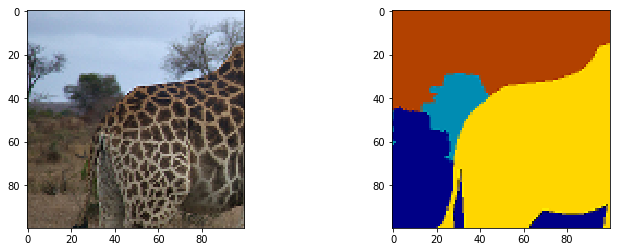

In [6]:
image_dir = os.path.join("data","images")
ds = ImageWithMaskDataset(root=image_dir, transform=joint_transform)
sample = ds.__getitem__(0)
assert len(sample) == 2
assert sample[0].shape == (100, 100, 3)
assert sample[1].shape == (100, 100, 3)
plot_mx_arrays([sample[0]*255, sample[1]*255])





# Summary

We've succesfully created a custom Dataset for images and corresponding masks, implemented an augmentation `transform` function that correctly handles masks, and applied it to each sample of the Dataset. You're now ready to train your own object segmentation models!

# Appendix (COCO Dataset)

[COCO dataset](http://cocodataset.org/) is a great resource for image segmentation data. It contains over 200k labelled images, with over 1.5 million object instances across 80 object categories. You can download the data using `gsutil` as per the instuctions below (from http://cocodataset.org/#download):

### 1) Install `gsutil`

```
curl https://sdk.cloud.google.com | bash
```

### 2) Download Images

We download the validation data from 2017 from `gs://images.cocodataset.org/val2017` as an example. It's a much more manageable size (~770MB) compared to the test and training data with are both > 5GB.

```
mkdir coco_data
mkdir coco_data/images
gsutil -m rsync gs://images.cocodataset.org/val2017 coco_data/images
```

### 3) Download Masks (a.k.a. pixel maps) 

```
gsutil -m cp gs://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip \
    coco_data/stuff_annotations_trainval2017.zip
unzip coco_data/stuff_annotations_trainval2017.zip
rm coco_data/stuff_annotations_trainval2017.zip
unzip annotations/stuff_val2017_pixelmaps.zip
rm -r annotations
mkdir coco_data/masks
mv -v stuff_val2017_pixelmaps/* coco_data/masks/
rm -r stuff_val2017_pixelmaps
```

<!-- INSERT SOURCE DOWNLOAD BUTTONS -->
